In [338]:
import numpy as np
import os
import cv2
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage import exposure
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Data verkenning
Met behulp van de YOLOv8 model zijn de afbeeldingen gecropt en gelabeld. De afbeeldingen zijn opgeslagen in twee mappen: correct_beer en incorrect_beer. In de map correct_beer staan de afbeeldingen die correct zijn gelabeld, en in de map incorrect_beer staan de afbeeldingen die incorrect zijn gelabeld. De afbeeldingen zijn opgeslagen als .jpg bestanden. (zie andere notebook)

Shape of X: (278, 128, 128, 3)
Shape of y: (278,)
Number of correct images: 84
Number of incorrect images: 194


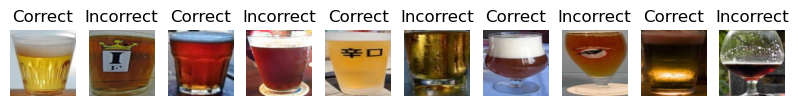

In [339]:
correct_dir = os.path.join('correct_beer')
incorrect_dir = os.path.join('incorrect_beer')

x = []
y = []
for image_name in os.listdir(correct_dir):
    image_path = os.path.join(correct_dir, image_name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # Resize for consistency
    x.append(img)
    y.append(1)  # Correct label

correct_dir_2 = os.path.join('extra_correct_beer')
for image_name in os.listdir(correct_dir_2):
    image_path = os.path.join(correct_dir_2, image_name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # Resize for consistency
    x.append(img)
    y.append(1)  # Correct label

for image_name in os.listdir(incorrect_dir):
    image_path = os.path.join(incorrect_dir, image_name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # Resize for consistency
    x.append(img)
    y.append(0)  # Incorrect label

X = np.array(x)
y = np.array(y)

#show shape of X and y, and the number of images in each class, and examples
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Number of correct images: {np.sum(y == 1)}")
print(f"Number of incorrect images: {np.sum(y == 0)}")

#show some examples of the images

def show_examples(images, labels, num_examples=5):
    plt.figure(figsize=(10, 10))
    direction = 1
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        img = images[direction*i].reshape(128, 128, 3)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title('Correct' if labels[direction*i] == 1 else 'Incorrect')
        plt.axis('off')
        direction *=-1
    plt.show()
show_examples(X, y, num_examples=10)

Er zijn 52 afbeeldingen in de map correct_beer en 194 afbeeldingen in de map incorrect_beer. Zoals te zien in de voorbeelden zijn de afbeeldingen erg verschillend van elkaar. Er is veel variatie in belichting, soort glas, en hoek van de foto.

## Gemiddelde kleurverloop in de horizontale richting, van alle afbeeldingen over elkaar heengelegd.
Door van alle afbeeldingen de gemiddelde kleur per rij te berekenen, en deze over elkaar heen te leggen, kunnen we een kleurverloop maken. Dit geeft een goed overzicht van de gemiddelde kleur van de afbeeldingen, en kan helpen bij het herkennen van het schuim bovenop het bier. We maken twee kleurverlopen, één voor de correcte afbeeldingen en één voor de incorrecte afbeeldingen. Deze worden vervolgens naast elkaar weergegeven.

Zoals te zien in het resultaat, heeft de gemiddelde kleur van de correcte afbeeldingen een duidelijker en helderder verloop, met een hogere concentratie van wit in de bovenste helft. Dit komt overeen met het schuim bovenop het bier. De gemiddelde kleur van de incorrecte afbeeldingen is veel minder consistent, het is waziger, wat er op wijst dat er meer variatie is in de afbeeldingen, en dat het schuim minder goed zichtbaar is. Dit komt waarschijnlijk doordat de afbeeldingen van incorrecte glazen vaak halfvol of leeg zijn, waardoor het schuim niet goed zichtbaar is.

Ongeveer pixels 5-20 zouden wit moeten zijn, als we kijken naar de onderstaande afbeelding. Daarnaast is het belangrijk dat de volgende pixels (30-60) een amber kleur hebben. Door het verschil in glazen heeft de onderkant van de afbeelding soms een andere kleur, speciaal glazen hebben immers vaak een lange dunne steel.

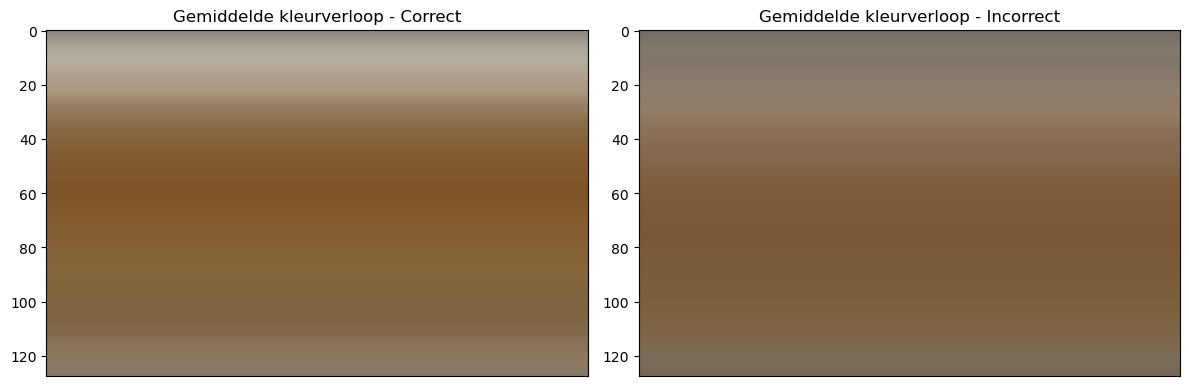

In [340]:
def average_color_gradient(images, stripe_height=50):
    avg_colors = []
    for img in images:
        if img.shape[2] == 3:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_rgb = img
        avg_per_row = np.mean(img_rgb, axis=1)
        avg_colors.append(avg_per_row)
    avg_colors = np.array(avg_colors)
    mean_gradient = np.mean(avg_colors, axis=0).astype(np.uint8)
    gradient_stripe = np.repeat(mean_gradient[:, np.newaxis, :], stripe_height, axis=1)
    return gradient_stripe

X_images = X.reshape(-1, 128, 128, 3)

correct_images = X_images[y == 1]
incorrect_images = X_images[y == 0]

correct_gradient = average_color_gradient(correct_images, stripe_height=200)
incorrect_gradient = average_color_gradient(incorrect_images, stripe_height=200)

plt.figure(figsize=(12, 6))

for i, (gradient, title) in enumerate(zip([correct_gradient, incorrect_gradient],
                                         ["Gemiddelde kleurverloop - Correct", "Gemiddelde kleurverloop - Incorrect"])):
    ax = plt.subplot(1, 2, i + 1)
    ax.imshow(gradient)
    ax.set_title(title)
    ax.axis('on')  # laat assen zien
    ax.set_xticks([])  # geen x-as ticks want dat is minder relevant
plt.tight_layout()
plt.show()

# Data preprocessing
## Feature extraction
Om de afbeeldingen te kunnen gebruiken voor het trainen van een model, moeten de afbeeldingen worden omgezet naar een formaat dat het model kan begrijpen. Dit wordt gedaan door feature extraction.
### Verschillende soorten features

- Color histograms
    - Telt de frequentie van elke kleur in de afbeelding, kan handig zijn om wit schuim, en amber kleur van bier te herkennen.
    - Simpel en snel, maar kan niet goed omgaan met variaties in belichting en kleur, en negeert de ruimtelijke structuur van de afbeelding (bijvoorbeeld of het schuim bovenop het bier zit of niet).
- Region-based color statistics
    - Meet de gemiddelde kleur van verschillende regio's in de afbeelding, zoals de bovenkant en onderkant van het glas.
    - Gebruikt de ruimtelijke structuur van de afbeelding, maar kan nog steeds problemen hebben met variaties in belichting en kleur.
- Histogram of Oriented Gradients (HOG)
    - Analyseert de randen en hoeken in de afbeelding, wat kan helpen bij het herkennen van de vorm van het glas en het schuim.
    - Negeert de kleurinformatie, maar is robuust tegen variaties in belichting en kleur.
- Edge detection
    - Detecteert de randen in de afbeelding, wat kan helpen bij het herkennen van de vorm van het glas en het schuim.
- Texture features
    - Analyseert de textuur van de afbeelding, wat kan helpen bij het herkennen van de schuimstructuur.
    - Kan nuttig zijn, maar is complexer en langzamer dan de andere methoden. Werkt ook het beste in grijschaal afbeeldingen.

### Gekozen features:
- Region-based color statistics

Schuim kleur is licht/wit en verschijnt in de bovenste regio van een correcte afbeelding. Het geeft ruimtelijke informatie wat color histograms niet doet.
- Color Histogram

Kan missend schuim detecteren, en is snel en eenvoudig te implementeren.
- Histogram of Oriented Gradients (HOG)

Handig voor het herkennen van de rand tussen het schuim en het bier, als die er is.



## Feature extraction code

In [341]:
def extract_features(images):
    all_features = []
    for image in images:
        # Resize to a consistent size
        image = cv2.resize(image, (128, 128))

        h = image.shape[0]
        third = h // 3

        foam = image[5:20, :]
        beer = image[30:60, :]

        # --- Wit-percentage in bovenste pixels (5-20) ---
        hsv_top = cv2.cvtColor(foam, cv2.COLOR_BGR2HSV)
        white_mask = cv2.inRange(hsv_top, (0, 0, 200), (180, 50, 255))
        white_ratio_top = np.sum(white_mask > 0) / white_mask.size

        # --- Gemiddelde kleur in middelste pixels (30-60) (HSV) ---
        hsv_mid = cv2.cvtColor(beer, cv2.COLOR_BGR2HSV)
        avg_hsv_mid = np.mean(hsv_mid.reshape(-1, 3), axis=0)

        # --- HOG features van volledige afbeelding ---
        gray_image = rgb2gray(image)
        hog_features = hog(gray_image, pixels_per_cell=(16, 16),
                           cells_per_block=(2, 2), feature_vector=True)

        # Combineer features
        features = np.concatenate(([white_ratio_top], avg_hsv_mid, hog_features))
        all_features.append(features)
    return all_features
features = extract_features(X)

## Analyse van de features
### Wit-percentage in bovenste derde
De volgende boxplot laat zien dat het wit-percentage in de bovenste derde van de afbeelding een goede feature is om onderscheid te maken tussen correcte en incorrecte afbeeldingen. Correcte afbeeldingen hebben een hoger wit-percentage, terwijl incorrecte afbeeldingen een lager wit-percentage hebben.

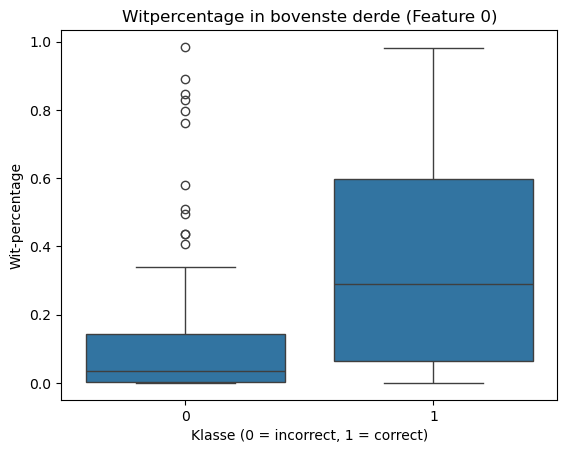

In [342]:
features = np.array(features)
df = pd.DataFrame(features)
df['label'] = y

# Wit-percentage bovenste derde
sns.boxplot(x='label', y=0, data=df)
plt.title("Witpercentage in bovenste derde (Feature 0)")
plt.xlabel("Klasse (0 = incorrect, 1 = correct)")
plt.ylabel("Wit-percentage")
plt.show()

### Gemiddelde kleur in de middelste derde (HSV)
Zoals te zien in de boxplots, bevat de incorrecte groep afbeeldingen veel meer uitschieters in de hue. Dit komt waarschijnlijk omdat de glazen hier slechts halfvol of leeg zijn. Verder is de saturatie iets lager bij de incorrecte groep.

<Figure size 1200x400 with 0 Axes>

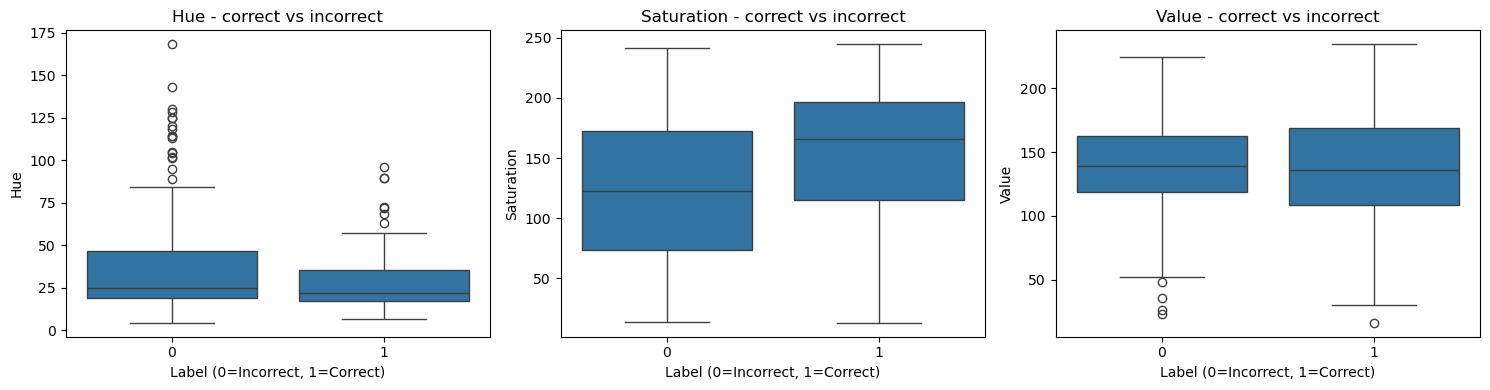

In [343]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(features[:, 1:4], columns=['Hue', 'Saturation', 'Value'])
df['label'] = y  # 1 = correct, 0 = incorrect

# Plot boxplots per kanaal gesplitst op label
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.boxplot(x='label', y='Hue', data=df)
plt.title('Hue - correct vs incorrect')
plt.xlabel('Label (0=Incorrect, 1=Correct)')

plt.subplot(1,3,2)
sns.boxplot(x='label', y='Saturation', data=df)
plt.title('Saturation - correct vs incorrect')
plt.xlabel('Label (0=Incorrect, 1=Correct)')

plt.subplot(1,3,3)
sns.boxplot(x='label', y='Value', data=df)
plt.title('Value - correct vs incorrect')
plt.xlabel('Label (0=Incorrect, 1=Correct)')

plt.tight_layout()
plt.show()


### Histogram of Oriented Gradients (HOG)
Hier onder zijn een aantal voorbeelden van de HOG-features van de afbeeldingen. De HOG-features zijn een goede manier om de randen en hoeken in de afbeelding te herkennen, wat kan helpen bij het herkennen van de vorm van het glas en het schuim. Door van alle afbeeldingen de HOG features te visualiseren, en te overlayen, kunnenn we zien dat er weinig tot geen duidelijk verschil lijkt te zijn in de HOG-features tussen de correcte en incorrecte afbeeldingen. Zo lijkt er bijvoorbeeld geen duidelijke schuim lijn te ontstaan bij de overlay van de correcte afbeeldingen. Dit suggereert dat HOG mogelijk niet de beste feature is voor deze specifieke taak, maar we zullen het toch gebruiken in ons model.

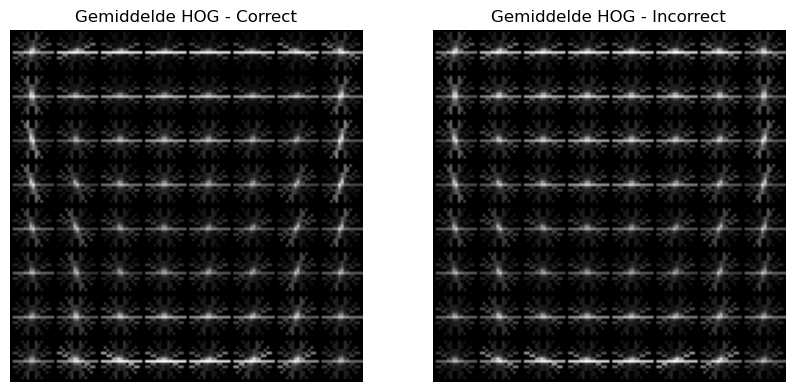

In [344]:
def average_hog_images(images, labels):
    # Prepare accumulators for sum of HOG visualizations and counts
    sum_hog_correct = None
    count_correct = 0
    sum_hog_incorrect = None
    count_incorrect = 0

    for img, label in zip(images, labels):
        img_reshaped = img.reshape(128,128,3)
        gray = cv2.cvtColor(img_reshaped, cv2.COLOR_BGR2GRAY)

        # Compute HOG with visualization
        _, hog_image = hog(gray,
                           pixels_per_cell=(16,16),
                           cells_per_block=(2,2),
                           visualize=True,
                           feature_vector=True)

        # Rescale for better numerical stability
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        if label == 1:
            if sum_hog_correct is None:
                sum_hog_correct = np.zeros_like(hog_image_rescaled, dtype=np.float64)
            sum_hog_correct += hog_image_rescaled
            count_correct += 1
        else:
            if sum_hog_incorrect is None:
                sum_hog_incorrect = np.zeros_like(hog_image_rescaled, dtype=np.float64)
            sum_hog_incorrect += hog_image_rescaled
            count_incorrect += 1

    # Calculate averages
    avg_hog_correct = sum_hog_correct / count_correct
    avg_hog_incorrect = sum_hog_incorrect / count_incorrect

    return avg_hog_correct, avg_hog_incorrect

avg_correct, avg_incorrect = average_hog_images(X, y)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(avg_correct, cmap='gray')
plt.title('Gemiddelde HOG - Correct')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(avg_incorrect, cmap='gray')
plt.title('Gemiddelde HOG - Incorrect')
plt.axis('off')

plt.show()

# Modelkeuze

We hebben een dataset van ongeveer 250 afbeeldingen van goed en slecht getapt bier. We extraheren visuele features zoals kleurverdeling (bijv. HSV), aanwezigheid van schuim (wit), en vormkenmerken (zoals HOG). Op basis daarvan kiezen we geschikte klassieke machine learning modellen.

Omdat het om een kleine dataset gaat en we werken met handmatig geëxtraheerde features, zijn klassieke modellen hier goed toepasbaar.

### Gekozen modellen

#### Support Vector Machine (SVM)

SVM zoekt de optimale scheidingslijn (of -vlak) tussen twee klassen. Met een RBF-kernel kan het ook niet-lineaire patronen leren.

Voordelen:
- Zeer accuraat bij kleine datasets
- Werkt uitstekend met HOG-features en hoge dimensionale data
- Kan complexe, niet-lineaire grenzen modelleren

Nadelen:
- Hyperparameter tuning vereist (bijv. C en gamma)
- Trager bij grotere datasets

Bronnen:
- https://scikit-learn.org/stable/modules/svm.html
Waarom gekozen:
De combinatie van kleur en vorm (schuim, bierlijn) is vaak niet-lineair scheidbaar. SVM met een RBF-kernel is daarom geschikt voor deze visuele classificatietaak.

#### Random Forest

Random Forest is een ensemble van beslissingsbomen dat robuuste voorspellingen maakt.

Voordelen:
- Robuust tegen overfitting
- Werkt goed met kleine datasets en gemengde features
- Geeft inzicht in feature importance

Nadelen:
- Minder effectief bij zeer hoge dimensionale data zoals volledige HOG-vectoren

Bronnen:
- https://scikit-learn.org/stable/modules/ensemble.html#forest

Waarom gekozen:
Ideaal bij gebruik van eenvoudige features (zoals gemiddelde kleur, wit-percentage). Ook nuttig als interpreteerbare tweede optie naast SVM.

#### Logistische Regressie (baseline)

Een eenvoudige lineaire classifier, handig als referentiepunt.

Voordelen:
- Simpel en snel
- Goed interpreteerbaar

Nadelen:
- Slechte prestaties bij niet-lineaire data

Bron:
- https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Waarom gekozen:
Niet als eindmodel, maar als eenvoudige baseline voor vergelijking.

### Modellen die we niet gebruiken

#### K-Nearest Neighbors (KNN)

- Slecht schaalbaar bij hoge dimensionale features zoals HOG
- Gevoelig voor ruis en irrelevante data

Bron: https://scikit-learn.org/stable/modules/neighbors.html

#### Naive Bayes

- Gaat uit van onafhankelijke features — dat klopt vaak niet bij beelddata
- Matige prestaties bij gecorreleerde visuele kenmerken

Bron: https://scikit-learn.org/stable/modules/naive_bayes.html

### Conclusie
Voor dit project kiezen we:
- SVM met RBF-kernel als hoofdmodel vanwege goede prestaties bij complexe, visuele data.
- Random Forest als interpreteerbare back-up die goed werkt met eenvoudigere features.
- Logistische Regressie gebruiken we als baseline ter vergelijking.

# Trainen van de modellen
In het volgende blok train ik de 3 modellen, op basis van de features die we hebben geëxtraheerd. We splitsen de data in een training- en testset, en gebruiken de training set om de modellen te trainen. Vervolgens testen we de modellen op de test set en printen we de classificatie rapporten.

Wat opvalt is dat geen van de modellen goed presteert. De hoogste accuracy score wordt behaalt door de random forest, echter is dit erg misleidend, omdat dit model alle afbeeldingen als incorrect classificeert. Dit komt omdat de dataset erg scheef is, met veel meer incorrecte afbeeldingen dan correcte afbeeldingen. Dit is een probleem dat we moeten oplossen, bijvoorbeeld door de dataset te balanceren of door gebruik te maken van andere technieken zoals oversampling of undersampling.

De SVM en logistische regressie presteren ook niet goed, met een lage accuracy en veel false positives. Dit komt waarschijnlijk doordat de features die we hebben geëxtraheerd niet voldoende zijn om de modellen goed te laten generaliseren.

## Support Vector Machine (SVM)

In [345]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Incorrect', 'Correct']))

SVM Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.78      0.38      0.51        37
     Correct       0.39      0.79      0.53        19

    accuracy                           0.52        56
   macro avg       0.59      0.58      0.52        56
weighted avg       0.65      0.52      0.51        56



## Random Forest

In [346]:
rnd_forest_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rnd_forest_model.fit(X_train, y_train)
y_pred_rf = rnd_forest_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Incorrect', 'Correct'], zero_division=0))


Random Forest Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.67      1.00      0.80        37
     Correct       1.00      0.05      0.10        19

    accuracy                           0.68        56
   macro avg       0.84      0.53      0.45        56
weighted avg       0.78      0.68      0.57        56



## Logistische Regressie

In [347]:
log_regression_model = SVC(kernel='linear', C=1.0, class_weight='balanced')
log_regression_model.fit(X_train, y_train)
y_pred_log = log_regression_model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log, target_names=['Incorrect', 'Correct'], zero_division=0))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.70      0.84      0.77        37
     Correct       0.50      0.32      0.39        19

    accuracy                           0.66        56
   macro avg       0.60      0.58      0.58        56
weighted avg       0.64      0.66      0.64        56



Confusion matrixen laten zien in hoeverre de modellen correct en incorrecte afbeeldingen classificeren.

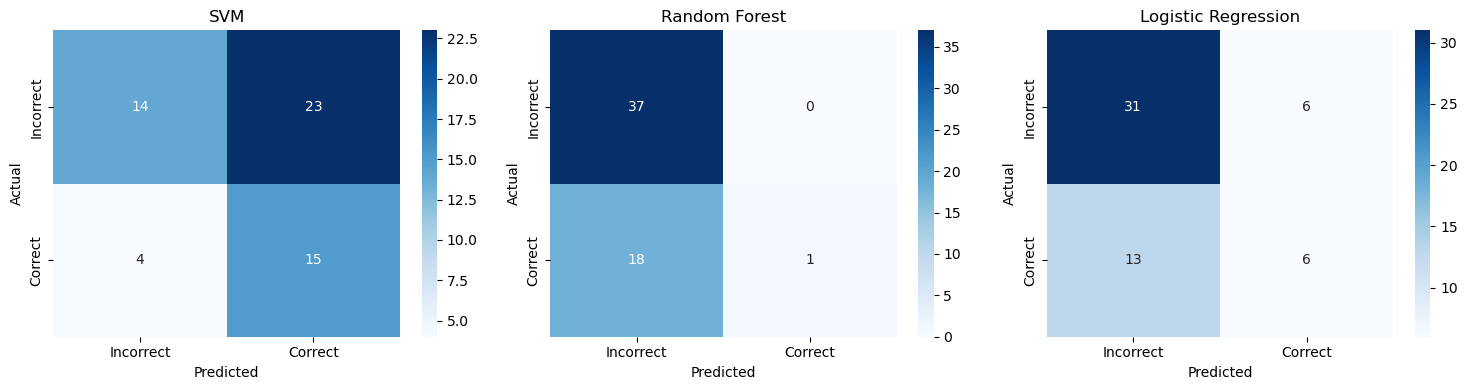

In [348]:
# Compute confusion matrices
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_log = confusion_matrix(y_test, y_pred_log)

# Plot all confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
titles = ['SVM', 'Random Forest', 'Logistic Regression']
cms = [cm_svm, cm_rf, cm_log]

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Incorrect', 'Correct'],
                yticklabels=['Incorrect', 'Correct'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

plt.tight_layout()
plt.show()

Er is duidelijk te weinig/ongebalanceerde data, daarom ga ik meer fotos zoeken en toevoegen aan de dataset. om de data gebalanceerd te maken, moet ik ongeveer 142 correcte afbeeldingen toevoegen.
Hiervoor ben ik naar Untappd.com gegaan, en heb ik fotos van getapt bier gedownload, en door de YOLOv8 model gehaald om de afbeeldingen te croppen (zie andere notebook). Het voordeel van Untappd.com, is dat de fotos op deze website geplaatst zijn door gewone consumenten, en er dus veel variatie is in de fotos